In [2]:
import pandas as pd
import calendar as cd
import numpy as np
import math 
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Dense
import os

DIRTY_FILE_NAME = 'ES=F.csv'
CLEAN_FILE_NAME = '(Clean)dowjones_stocks.csv'

ModuleNotFoundError: No module named 'sklearn'

## DATA EXTRACTION AND CLEANING AND FORMATTING
### Data Extraction
Putting the S&P 500 csv data into a dataframe

In [238]:
if os.path.exists(DIRTY_FILE_NAME):
    dowjones_stocks = pd.read_csv(DIRTY_FILE_NAME)
    print(dowjones_stocks.head())
else:
    print("Error: Input file not found")

         Date     Open     High      Low   Close  Adj Close    Volume
0  2000-09-18  1485.25  1489.75  1462.25  1467.5     1467.5  104794.0
1  2000-09-19  1467.00  1482.75  1466.75  1478.5     1478.5  103371.0
2  2000-09-20  1478.75  1480.50  1450.25  1469.5     1469.5  109667.0
3  2000-09-21  1470.25  1474.00  1455.50  1469.5     1469.5   98528.0
4  2000-09-22  1454.75  1471.00  1436.75  1468.5     1468.5   97416.0


### Data Cleaning

The S&P 500 stock price dataset contains a number of null records typically during holidays or weekends, which are days when the stock market is closed. To clean this dataset, we will simply remove all null records. Due to the missing dates, it should be noted that the stock price forecasting model will not predict stock prices for each subsequent days. Rather, we should assume that the forecasting model will predict stock prices for the next subsequent day in which the stock price would typically be observed and recorded (i.e. non-weekends and non-holidays).

In [239]:
dowjones_stocks_cleaned = dowjones_stocks.loc[dowjones_stocks["Open"].isnull() == False]
dowjones_stocks_cleaned

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,1485.25,1489.75,1462.25,1467.50,1467.50,104794.0
1,2000-09-19,1467.00,1482.75,1466.75,1478.50,1478.50,103371.0
2,2000-09-20,1478.75,1480.50,1450.25,1469.50,1469.50,109667.0
3,2000-09-21,1470.25,1474.00,1455.50,1469.50,1469.50,98528.0
4,2000-09-22,1454.75,1471.00,1436.75,1468.50,1468.50,97416.0
...,...,...,...,...,...,...,...
6189,2020-11-16,3587.00,3637.00,3586.50,3623.00,3623.00,1303941.0
6190,2020-11-17,3625.50,3630.00,3584.25,3606.75,3606.75,1268206.0
6191,2020-11-18,3604.50,3623.25,3556.50,3565.00,3565.00,1325309.0
6192,2020-11-19,3562.00,3582.75,3542.25,3580.00,3580.00,1291117.0


Check if there are any null values left in the dataset. There are none left.

In [240]:
dowjones_stocks_cleaned.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [241]:
#save cleaned data without the index column.
dowjones_stocks_cleaned.to_csv(CLEAN_FILE_NAME, index=0)

## BREAK POINT 1: Data Cleaned and saved till here. Can begin from here if saved file is available

In [242]:
if os.path.exists(CLEAN_FILE_NAME):
    dowjones_stocks_cleaned = pd.read_csv(CLEAN_FILE_NAME,index_col=['Date'])
    print(dowjones_stocks_cleaned.head())
else:
    print("Error: Clean File not found. Restart from the beginning")

               Open     High      Low   Close  Adj Close    Volume
Date                                                              
2000-09-18  1485.25  1489.75  1462.25  1467.5     1467.5  104794.0
2000-09-19  1467.00  1482.75  1466.75  1478.5     1478.5  103371.0
2000-09-20  1478.75  1480.50  1450.25  1469.5     1469.5  109667.0
2000-09-21  1470.25  1474.00  1455.50  1469.5     1469.5   98528.0
2000-09-22  1454.75  1471.00  1436.75  1468.5     1468.5   97416.0


# Splitting the Data

We have 10 years worth of data. Will use 9 years of data to predict the last year.
Will break the data down into weekly data and then use that to predict the daily closing price for each day a for a week. We will also remove the "Adjusted Close" column as it is the same as the "Close" column.

In [243]:
dowjones_stocks_cleaned_copy = dowjones_stocks_cleaned.copy()
del dowjones_stocks_cleaned_copy["Adj Close"]
dowjones_stocks_cleaned_copy

,Open,High,Low,Close,Volume
Date,,,,,
2000-09-18,1485.25,1489.75,1462.25,1467.50,104794.0
2000-09-19,1467.00,1482.75,1466.75,1478.50,103371.0
2000-09-20,1478.75,1480.50,1450.25,1469.50,109667.0
2000-09-21,1470.25,1474.00,1455.50,1469.50,98528.0
2000-09-22,1454.75,1471.00,1436.75,1468.50,97416.0
...,...,...,...,...,...
2020-11-16,3587.00,3637.00,3586.50,3623.00,1303941.0
2020-11-17,3625.50,3630.00,3584.25,3606.75,1268206.0
2020-11-18,3604.50,3623.25,3556.50,3565.00,1325309.0


In [244]:
def split(dataset):
    dataset = dataset.values
    length = len(dataset)
    print("Length=",length)
    total_weeks = int(length/5)
    print("Total Weeks=",total_weeks)
    
    #use last 1 year as test data set, everything else as train dataset
    WEEKS_IN_ONE_YEAR = 52
    ONE_YEAR_WORK_DAYS = 5*52
    
    train = dataset[0:-ONE_YEAR_WORK_DAYS]
    test = dataset[-ONE_YEAR_WORK_DAYS:]
    
    #convert to array
    train = np.array(train)
    test = np.array(test)
    
    print("-----TRAIN DATA-----")
    print("Length=",len(train))
    print("-----TEST DATA-----")
    print("Length=",len(test))
    print(train[0])
    print(test[0])
    return train,test
    
train_data,test_data = split(dowjones_stocks_cleaned_copy)

Length= 5131
Total Weeks= 1026
-----TRAIN DATA-----
Length= 4871
-----TEST DATA-----
Length= 260
[  1485.25   1489.75   1462.25   1467.5  104794.  ]
[   3237.      3261.75    3234.25    3259.   1416241.  ]


### What to predict?
Use 15 days of the available data with features Open Price, High, Low, Close, and Volume to predict the next 5 days of Close Price.

In [245]:
COLUMN_TO_PREDICT = 3 #Closing cost for the day
NUMBER_OF_DAYS_DATA_TO_USE = 15
NUMBER_OF_DAYS_DATA_TO_PREDICT = 5
NUMBER_OF_COLUMNS = train_data.shape[1]

#split the given data into inputs and outputs. We can use last 7 days data to predict the next day 
# or we can use monthly data to predict. It depends onm how we want to model the data
# and will experiment with various models
#if column_with_result is None, then trying to make data for validation
def convert_data_into_io(input_data, steps, column_with_result, num_of_days_to_predict):
    print(column_with_result)
    x,y = list(), list()
    
    for i in range(len(input_data)):
        end = i + steps
        if end+1 > len(input_data) or end+num_of_days_to_predict > len(input_data):
            break
        
        _x = input_data[i:end,]
        
        _y = input_data[end:end+num_of_days_to_predict,column_with_result]
        
        y.append(_y)
        x.append(_x)
        
    return np.array(x), np.array(y)

In [246]:
train_x,train_y = convert_data_into_io(train_data,NUMBER_OF_DAYS_DATA_TO_USE,COLUMN_TO_PREDICT,NUMBER_OF_DAYS_DATA_TO_PREDICT)
print("------------------------")
print("Total Train Data:", len(train_x))
print("Sample Train Input Data:")
print(train_x[0])
print("Sample Train Output Data:")
print(train_y[0])
print("------------------------")

test_x,test_y = convert_data_into_io(test_data,NUMBER_OF_DAYS_DATA_TO_USE,COLUMN_TO_PREDICT,NUMBER_OF_DAYS_DATA_TO_PREDICT)
print("------------------------")
print("Total Test Data:", len(test_x))
print("Sample Test Input Data:")
print(test_x[0])
print("Sample Test Output Data:")
print(test_y[0])
print("-------------------------")

3
------------------------
Total Train Data: 4852
Sample Train Input Data:
[[  1485.25   1489.75   1462.25   1467.5  104794.  ]
 [  1467.     1482.75   1466.75   1478.5  103371.  ]
 [  1478.75   1480.5    1450.25   1469.5  109667.  ]
 [  1470.25   1474.     1455.5    1469.5   98528.  ]
 [  1454.75   1471.     1436.75   1468.5   97416.  ]
 [  1469.5    1477.75   1455.5    1461.    85491.  ]
 [  1461.     1467.     1442.5    1443.    99803.  ]
 [  1444.     1456.     1438.25   1446.75 101996.  ]
 [  1447.75   1481.     1445.     1476.    84280.  ]
 [  1473.     1473.25   1454.     1454.    78277.  ]
 [  1453.75   1464.25   1447.5    1456.25  84100.  ]
 [  1457.25   1474.     1438.75   1441.5   89440.  ]
 [  1442.     1457.25   1432.5    1450.25 101607.  ]
 [  1449.5    1462.     1447.25   1456.    92232.  ]
 [  1456.     1460.5    1411.5    1426.25  95257.  ]]
Sample Train Output Data:
[1416.5  1391.   1378.5  1344.   1386.25]
------------------------
3
------------------------
Total Tes

## LSTM Model (2000 Epochs with ADAM)
Creating a 5 day closing stock price forecasting model with LSTM with 2000 epochs using adam

In [209]:
# Number of epochs and optimizer
epochs = 2000
optimizer = "adam"

# Number of features
num_features = train_x.shape[2]

# name of model and history 
model_name_1 = "stock_model_1.h5"
history_name_1 = "stock_model_history_1.csv"

# The model
def stock_model(num_features, epochs, opt, model_name, history_name):
    stock_model = keras.Sequential()
    stock_model.add(LSTM(100, activation='relu', return_sequences=False, input_shape=(NUMBER_OF_DAYS_DATA_TO_USE, num_features)))
    stock_model.add(Dense(NUMBER_OF_DAYS_DATA_TO_PREDICT))

    print(stock_model.summary())
    
    stock_model.compile(optimizer=opt, loss='mae')
    stock_model_history = stock_model.fit(train_x, train_y, epochs=epochs, validation_data=(test_x, test_y))
    
    stock_model.save(model_name)

    pd.DataFrame(stock_model_history.history).to_csv(history_name)
    
    return stock_model, stock_model_history

Loading the forecasting model with 2000 epochs if it exists. If not, run the forecasting model and fit a new model.

In [210]:
#SAVE MODEL AFTER FITTING. If saved model is available, then reload that
model = None
model_history = pd.DataFrame()

if os.path.exists(model_name_1):
    print("Model Found: Loading...")
    model = load_model(model_name_1)
    model_history = pd.read_csv(history_name_1)
    print(model.summary())
    print("Model Loaded!")
else:
    print("Model not Found. Fitting model...")
    model, model_history = stock_model(num_features, epochs, optimizer, model_name_1, history_name_1)
    model_history = model_history.history

Model not Found. Fitting model...
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 505       
Total params: 42,905
Trainable params: 42,905
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2000
152/152 [==============================] - 1s 9ms/step - loss: 59539.6914 - val_loss: 39544.9805
Epoch 2/2000
152/152 [==============================] - 1s 7ms/step - loss: 22573.1191 - val_loss: 10981.3018
Epoch 3/2000
152/152 [==============================] - 1s 7ms/step - loss: 10430.2861 - val_loss: 24568.5664
Epoch 4/2000
152/152 [==============================] - 1s 7ms/step - loss: 12156.4316 - val_loss: 10070.1289
Epoch 5/2000
152/152 [===========

152/152 [==============================] - 1s 7ms/step - loss: 273.9374 - val_loss: 316.5369
Epoch 72/2000
152/152 [==============================] - 1s 7ms/step - loss: 260.7020 - val_loss: 422.8561
Epoch 73/2000
152/152 [==============================] - 1s 7ms/step - loss: 281.8088 - val_loss: 977.2336
Epoch 74/2000
152/152 [==============================] - 1s 7ms/step - loss: 327.7099 - val_loss: 302.9370
Epoch 75/2000
152/152 [==============================] - 1s 7ms/step - loss: 245.2520 - val_loss: 591.9403
Epoch 76/2000
152/152 [==============================] - 1s 7ms/step - loss: 267.6151 - val_loss: 338.8465
Epoch 77/2000
152/152 [==============================] - 1s 7ms/step - loss: 221.5157 - val_loss: 629.9173
Epoch 78/2000
152/152 [==============================] - 1s 7ms/step - loss: 274.3900 - val_loss: 537.1777
Epoch 79/2000
152/152 [==============================] - 1s 7ms/step - loss: 192.2340 - val_loss: 1333.2941
Epoch 80/2000
152/152 [===========================

152/152 [==============================] - 1s 7ms/step - loss: 72.2360 - val_loss: 181.5716
Epoch 225/2000
152/152 [==============================] - 1s 7ms/step - loss: 68.8891 - val_loss: 180.1494
Epoch 226/2000
152/152 [==============================] - 1s 7ms/step - loss: 59.6781 - val_loss: 154.3316
Epoch 227/2000
152/152 [==============================] - 1s 7ms/step - loss: 56.0311 - val_loss: 154.4596
Epoch 228/2000
152/152 [==============================] - 1s 7ms/step - loss: 60.1278 - val_loss: 158.4207
Epoch 229/2000
152/152 [==============================] - 1s 7ms/step - loss: 47.9853 - val_loss: 144.8480
Epoch 230/2000
152/152 [==============================] - 1s 7ms/step - loss: 48.6278 - val_loss: 144.4753
Epoch 231/2000
152/152 [==============================] - 1s 7ms/step - loss: 50.8540 - val_loss: 147.5218
Epoch 232/2000
152/152 [==============================] - 1s 7ms/step - loss: 46.3406 - val_loss: 129.6383
Epoch 233/2000
152/152 [============================

152/152 [==============================] - 1s 7ms/step - loss: 26.2101 - val_loss: 84.1768
Epoch 302/2000
152/152 [==============================] - 1s 7ms/step - loss: 27.1273 - val_loss: 76.4280
Epoch 303/2000
152/152 [==============================] - 1s 7ms/step - loss: 28.9069 - val_loss: 76.8619
Epoch 304/2000
152/152 [==============================] - 1s 7ms/step - loss: 32.6551 - val_loss: 87.7942
Epoch 305/2000
152/152 [==============================] - 1s 7ms/step - loss: 33.9899 - val_loss: 86.6134
Epoch 306/2000
152/152 [==============================] - 1s 7ms/step - loss: 28.3628 - val_loss: 81.7123
Epoch 307/2000
152/152 [==============================] - 1s 7ms/step - loss: 31.1225 - val_loss: 75.4264
Epoch 308/2000
152/152 [==============================] - 1s 7ms/step - loss: 34.1114 - val_loss: 93.6254
Epoch 309/2000
152/152 [==============================] - 1s 7ms/step - loss: 34.3072 - val_loss: 80.2638
Epoch 310/2000
152/152 [==============================] - 1s 

152/152 [==============================] - 1s 7ms/step - loss: 24.0451 - val_loss: 70.0302
Epoch 456/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.3480 - val_loss: 68.8889
Epoch 457/2000
152/152 [==============================] - 1s 7ms/step - loss: 28.8644 - val_loss: 77.2475
Epoch 458/2000
152/152 [==============================] - 1s 7ms/step - loss: 40.0357 - val_loss: 69.9264
Epoch 459/2000
152/152 [==============================] - 1s 7ms/step - loss: 34.1688 - val_loss: 72.6148
Epoch 460/2000
152/152 [==============================] - 1s 7ms/step - loss: 30.1653 - val_loss: 69.8210
Epoch 461/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.9531 - val_loss: 69.7966
Epoch 462/2000
152/152 [==============================] - 1s 7ms/step - loss: 28.3652 - val_loss: 82.7781
Epoch 463/2000
152/152 [==============================] - 1s 7ms/step - loss: 28.6278 - val_loss: 73.9957
Epoch 464/2000
152/152 [==============================] - 1s 

152/152 [==============================] - 1s 7ms/step - loss: 24.2774 - val_loss: 67.5246
Epoch 610/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.7812 - val_loss: 74.6693
Epoch 611/2000
152/152 [==============================] - 1s 7ms/step - loss: 25.9748 - val_loss: 83.7412
Epoch 612/2000
152/152 [==============================] - 1s 7ms/step - loss: 26.2074 - val_loss: 74.0599
Epoch 613/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.1586 - val_loss: 74.6097
Epoch 614/2000
152/152 [==============================] - 1s 7ms/step - loss: 30.5056 - val_loss: 68.6733
Epoch 615/2000
152/152 [==============================] - 1s 7ms/step - loss: 24.5741 - val_loss: 71.4414
Epoch 616/2000
152/152 [==============================] - 1s 7ms/step - loss: 24.1895 - val_loss: 89.8456
Epoch 617/2000
152/152 [==============================] - 1s 7ms/step - loss: 36.4011 - val_loss: 69.5856
Epoch 618/2000
152/152 [==============================] - 1s 

152/152 [==============================] - 1s 7ms/step - loss: 22.6992 - val_loss: 71.0512
Epoch 764/2000
152/152 [==============================] - 1s 7ms/step - loss: 24.1094 - val_loss: 81.6293
Epoch 765/2000
152/152 [==============================] - 1s 7ms/step - loss: 25.6821 - val_loss: 68.9963
Epoch 766/2000
152/152 [==============================] - 1s 7ms/step - loss: 26.7340 - val_loss: 80.6602
Epoch 767/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.6653 - val_loss: 69.7641
Epoch 768/2000
152/152 [==============================] - 1s 7ms/step - loss: 24.1112 - val_loss: 71.2561
Epoch 769/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.3759 - val_loss: 90.3408
Epoch 770/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.2901 - val_loss: 74.7437
Epoch 771/2000
152/152 [==============================] - 1s 7ms/step - loss: 27.1114 - val_loss: 80.4431
Epoch 772/2000
152/152 [==============================] - 1s 

152/152 [==============================] - 1s 7ms/step - loss: 24.6878 - val_loss: 70.2347
Epoch 918/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.6845 - val_loss: 68.9036
Epoch 919/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.8698 - val_loss: 93.0624
Epoch 920/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.4385 - val_loss: 69.8996
Epoch 921/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.5135 - val_loss: 75.2443
Epoch 922/2000
152/152 [==============================] - 1s 7ms/step - loss: 25.3519 - val_loss: 68.9919
Epoch 923/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.8987 - val_loss: 68.2642
Epoch 924/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.1726 - val_loss: 67.8298
Epoch 925/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.6499 - val_loss: 78.8689
Epoch 926/2000
152/152 [==============================] - 1s 

152/152 [==============================] - 1s 7ms/step - loss: 22.8347 - val_loss: 84.4854
Epoch 1071/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.4439 - val_loss: 72.4071
Epoch 1072/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.9954 - val_loss: 68.7711
Epoch 1073/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.8584 - val_loss: 69.6981
Epoch 1074/2000
152/152 [==============================] - 1s 7ms/step - loss: 20.9653 - val_loss: 68.6632
Epoch 1075/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.8130 - val_loss: 77.4304
Epoch 1076/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.3654 - val_loss: 70.4887
Epoch 1077/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.5229 - val_loss: 68.4339
Epoch 1078/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.5722 - val_loss: 70.4763
Epoch 1079/2000
152/152 [============================

152/152 [==============================] - 1s 7ms/step - loss: 20.3972 - val_loss: 68.2832
Epoch 1223/2000
152/152 [==============================] - 1s 7ms/step - loss: 20.9532 - val_loss: 68.2551
Epoch 1224/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.0764 - val_loss: 68.3027
Epoch 1225/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.4180 - val_loss: 83.0188
Epoch 1226/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.7412 - val_loss: 68.9788
Epoch 1227/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.4586 - val_loss: 68.0656
Epoch 1228/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.7118 - val_loss: 68.6746
Epoch 1229/2000
152/152 [==============================] - 1s 7ms/step - loss: 24.9938 - val_loss: 68.2680
Epoch 1230/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.2200 - val_loss: 93.6696
Epoch 1231/2000
152/152 [============================

152/152 [==============================] - 1s 7ms/step - loss: 21.2595 - val_loss: 68.0090
Epoch 1375/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.0382 - val_loss: 71.5826
Epoch 1376/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.5458 - val_loss: 68.0622
Epoch 1377/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.0889 - val_loss: 86.5463
Epoch 1378/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.9101 - val_loss: 71.4379
Epoch 1379/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.0999 - val_loss: 70.8040
Epoch 1380/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.1383 - val_loss: 67.8910
Epoch 1381/2000
152/152 [==============================] - 1s 7ms/step - loss: 20.4802 - val_loss: 69.4835
Epoch 1382/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.8994 - val_loss: 69.6354
Epoch 1383/2000
152/152 [============================

152/152 [==============================] - 1s 7ms/step - loss: 20.3548 - val_loss: 76.1993
Epoch 1527/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.7265 - val_loss: 67.9135
Epoch 1528/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.0139 - val_loss: 71.3724
Epoch 1529/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.1256 - val_loss: 68.4000
Epoch 1530/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.8885 - val_loss: 67.5923
Epoch 1531/2000
152/152 [==============================] - 1s 7ms/step - loss: 20.7738 - val_loss: 71.6780
Epoch 1532/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.2671 - val_loss: 68.8645
Epoch 1533/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.8933 - val_loss: 75.5950
Epoch 1534/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.9106 - val_loss: 70.0794
Epoch 1535/2000
152/152 [============================

152/152 [==============================] - 1s 7ms/step - loss: 20.5813 - val_loss: 70.5740
Epoch 1679/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.0256 - val_loss: 71.1564
Epoch 1680/2000
152/152 [==============================] - 1s 7ms/step - loss: 20.6573 - val_loss: 69.0526
Epoch 1681/2000
152/152 [==============================] - 1s 8ms/step - loss: 21.4890 - val_loss: 82.5111
Epoch 1682/2000
152/152 [==============================] - 1s 9ms/step - loss: 21.8056 - val_loss: 67.6511
Epoch 1683/2000
152/152 [==============================] - 1s 8ms/step - loss: 21.4625 - val_loss: 69.6253
Epoch 1684/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.3588 - val_loss: 69.9495
Epoch 1685/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.0797 - val_loss: 77.1682
Epoch 1686/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.4499 - val_loss: 70.7066
Epoch 1687/2000
152/152 [============================

152/152 [==============================] - 1s 7ms/step - loss: 21.9562 - val_loss: 68.4800
Epoch 1831/2000
152/152 [==============================] - 1s 7ms/step - loss: 19.9154 - val_loss: 68.3916
Epoch 1832/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.5904 - val_loss: 69.0558
Epoch 1833/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.8641 - val_loss: 73.3221
Epoch 1834/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.8741 - val_loss: 68.2792
Epoch 1835/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.3608 - val_loss: 69.2940
Epoch 1836/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.1444 - val_loss: 68.4071
Epoch 1837/2000
152/152 [==============================] - 1s 7ms/step - loss: 20.9853 - val_loss: 68.9311
Epoch 1838/2000
152/152 [==============================] - 1s 7ms/step - loss: 20.3070 - val_loss: 68.9849
Epoch 1839/2000
152/152 [============================

152/152 [==============================] - 1s 7ms/step - loss: 21.1477 - val_loss: 73.0734
Epoch 1983/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.9958 - val_loss: 68.6409
Epoch 1984/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.5339 - val_loss: 73.8306
Epoch 1985/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.2250 - val_loss: 67.3770
Epoch 1986/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.5919 - val_loss: 73.8813
Epoch 1987/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.0602 - val_loss: 68.3942
Epoch 1988/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.2498 - val_loss: 69.8657
Epoch 1989/2000
152/152 [==============================] - 1s 7ms/step - loss: 20.2986 - val_loss: 67.5270
Epoch 1990/2000
152/152 [==============================] - 1s 7ms/step - loss: 20.2798 - val_loss: 72.2137
Epoch 1991/2000
152/152 [============================

Plotting the loss

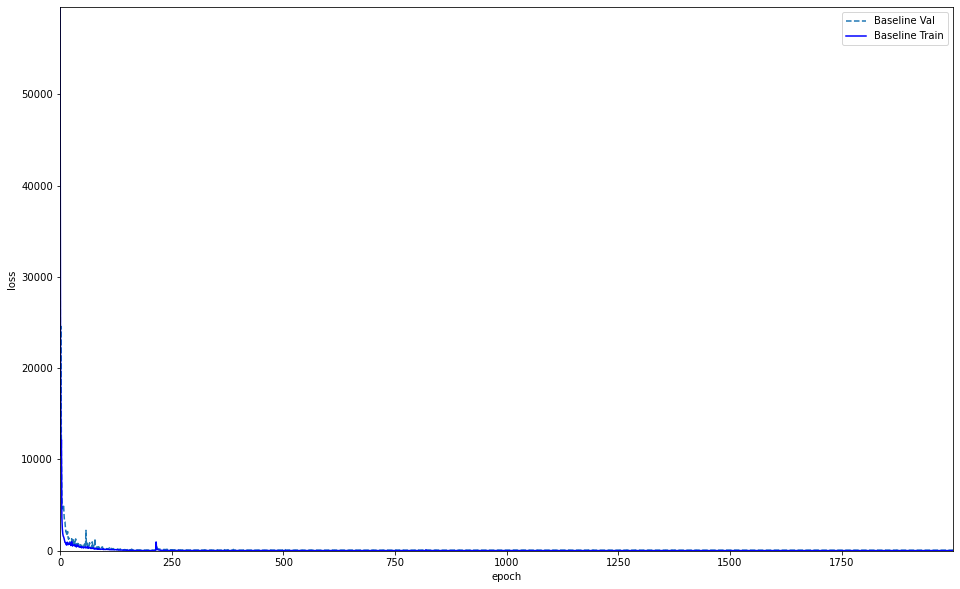

In [211]:
plt.figure(figsize=(16,10))
plt.plot(np.arange(0,epochs,1), model_history['val_loss'],'--', label='Baseline Val')
plt.plot(np.arange(0,epochs,1), model_history['loss'], color='blue', label='Baseline Train')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.xlim([0,max(np.arange(0,epochs,1))])
plt.ylim([0,max(max(model_history['val_loss']),max(model_history['loss']))])
plt.legend()
plt.show()

In [212]:
#function for preditions and error calculating
def predict(model, input_data):
    input_data = input_data.reshape(1,NUMBER_OF_DAYS_DATA_TO_USE,NUMBER_OF_COLUMNS)
    value = model.predict(input_data, verbose=0)
    return value[0][0]

def check_all_test_data(data, model):
    predicted_data = []
    i = 1
    for d in data:
        print('.',end='')
        if i%20 == 0: print('-',i)
        d = d.reshape((1, NUMBER_OF_DAYS_DATA_TO_USE, NUMBER_OF_COLUMNS))
        # below predicts the first value of the 5 predicted values
        data = model.predict(d)
        predicted_data.append(list(data[0]))
        i = i+1
    print('-',i)
    return np.array(predicted_data)

Predict values for the validation data

In [213]:
test_x,actual_y = convert_data_into_io(test_data,NUMBER_OF_DAYS_DATA_TO_USE,COLUMN_TO_PREDICT,NUMBER_OF_DAYS_DATA_TO_PREDICT)
print("Start predicting data...")
predicted_y = check_all_test_data(test_x, model)
print("End of data prediction!")

3
Start predicting data...
....................- 20
....................- 40
....................- 60
....................- 80
....................- 100
....................- 120
....................- 140
....................- 160
....................- 180
....................- 200
....................- 220
....................- 240
.- 242
End of data prediction!


#### from matplotlib import pyplot as plt
Below data shows the first predicted day of each set of 5 days that were predicted from each set of 15 prior days

from sklearn.metrics import mean_squared_error
import math 

#plot actual and predicted
x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, predicted_y, label='predicted data')
plt.plot(x_axis, actual_y[:,0], label='actual data')
plt.legend()


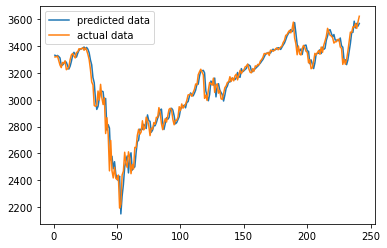

In [214]:
x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, predicted_y[:,0], label='predicted data')
plt.plot(x_axis, actual_y[:,0], label='actual data')
plt.legend()

Calculates the MSE, RMSE, and visualizes the percentage differences for each set of predicted values when compared to the real closing prices.

RMSE =  97.99438128763225


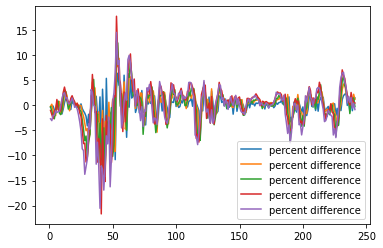

In [215]:
#print RMSE
mse = mean_squared_error(actual_y, predicted_y)
rmse = math.sqrt(mse)
print("RMSE = ",rmse)

def percent_diff(actual, predicted):
    return ((actual-predicted)/actual) * 100

#get percent difference between actual and predicted
difference = []
for i in range(0,len(actual_y)):
    difference.append(percent_diff(actual_y[i],predicted_y[i]))

x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, difference, label='percent difference')
plt.legend()

## LSTM MODEL (2000 Epochs with RMSPROP)
Creating a 5 day closing stock price forecasting model with LSTM with 2000 epochs using rmsprop

In [216]:
optimizer_2 = "rmsprop"
model_name_2 = "stock_model_2.h5"
history_name_2 = "stock_model_history_2.csv"

Running the model that uses RMSprop if it exists

In [217]:
model_2 = None
model_history_2 = pd.DataFrame()

if os.path.exists(model_name_2):
    print("Model Found: Loading...")
    model_2 = load_model(model_name_2)
    model_history_2 = pd.read_csv(history_name_2)
    print(model_2.summary())
    print("Model Loaded!")
else:
    print("Model not Found. Fitting model...")
    model_2, model_history_2 = stock_model(num_features, epochs, optimizer_2, model_name_2, history_name_2)
    model_history_2 = model_history_2.history

Model not Found. Fitting model...
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 100)               42400     
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 505       
Total params: 42,905
Trainable params: 42,905
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2000
152/152 [==============================] - 1s 9ms/step - loss: 79869.7578 - val_loss: 46965.1875
Epoch 2/2000
152/152 [==============================] - 1s 7ms/step - loss: 23627.5859 - val_loss: 33412.2188
Epoch 3/2000
152/152 [==============================] - 1s 7ms/step - loss: 13731.8760 - val_loss: 15907.3672
Epoch 4/2000
152/152 [==============================] - 1s 7ms/step - loss: 6960.6802 - val_loss: 7928.9585
Epoch 5/2000
152/152 [=============

152/152 [==============================] - 1s 6ms/step - loss: 94.7594 - val_loss: 138.8077
Epoch 148/2000
152/152 [==============================] - 1s 7ms/step - loss: 92.0829 - val_loss: 197.7938
Epoch 149/2000
152/152 [==============================] - 1s 6ms/step - loss: 90.9097 - val_loss: 215.2166
Epoch 150/2000
152/152 [==============================] - 1s 7ms/step - loss: 92.9369 - val_loss: 196.2108
Epoch 151/2000
152/152 [==============================] - 1s 6ms/step - loss: 92.9078 - val_loss: 133.2754
Epoch 152/2000
152/152 [==============================] - 1s 6ms/step - loss: 88.8766 - val_loss: 154.7815
Epoch 153/2000
152/152 [==============================] - 1s 6ms/step - loss: 93.8998 - val_loss: 217.0054
Epoch 154/2000
152/152 [==============================] - 1s 6ms/step - loss: 90.0482 - val_loss: 174.6668
Epoch 155/2000
152/152 [==============================] - 1s 6ms/step - loss: 87.3483 - val_loss: 147.6659
Epoch 156/2000
152/152 [============================

152/152 [==============================] - 1s 7ms/step - loss: 61.7203 - val_loss: 112.5122
Epoch 300/2000
152/152 [==============================] - 1s 7ms/step - loss: 61.2202 - val_loss: 203.7601
Epoch 301/2000
152/152 [==============================] - 1s 7ms/step - loss: 62.4784 - val_loss: 183.0710
Epoch 302/2000
152/152 [==============================] - 1s 7ms/step - loss: 60.2900 - val_loss: 134.6347
Epoch 303/2000
152/152 [==============================] - 1s 7ms/step - loss: 61.6586 - val_loss: 113.9987
Epoch 304/2000
152/152 [==============================] - 1s 7ms/step - loss: 59.5741 - val_loss: 99.3094
Epoch 305/2000
152/152 [==============================] - 1s 7ms/step - loss: 61.3734 - val_loss: 139.7100
Epoch 306/2000
152/152 [==============================] - 1s 7ms/step - loss: 62.0058 - val_loss: 179.2345
Epoch 307/2000
152/152 [==============================] - 1s 7ms/step - loss: 60.2801 - val_loss: 130.7423
Epoch 308/2000
152/152 [=============================

152/152 [==============================] - 1s 6ms/step - loss: 54.5506 - val_loss: 161.2464
Epoch 452/2000
152/152 [==============================] - 1s 6ms/step - loss: 57.0696 - val_loss: 121.5273
Epoch 453/2000
152/152 [==============================] - 1s 6ms/step - loss: 55.8294 - val_loss: 139.3509
Epoch 454/2000
152/152 [==============================] - 1s 6ms/step - loss: 55.9333 - val_loss: 111.3858
Epoch 455/2000
152/152 [==============================] - 1s 6ms/step - loss: 55.8267 - val_loss: 105.5217
Epoch 456/2000
152/152 [==============================] - 1s 6ms/step - loss: 54.5760 - val_loss: 142.2714
Epoch 457/2000
152/152 [==============================] - 1s 7ms/step - loss: 55.5840 - val_loss: 127.1232
Epoch 458/2000
152/152 [==============================] - 1s 6ms/step - loss: 56.3944 - val_loss: 174.4410
Epoch 459/2000
152/152 [==============================] - 1s 7ms/step - loss: 55.0173 - val_loss: 134.3802
Epoch 460/2000
152/152 [============================

152/152 [==============================] - 1s 6ms/step - loss: 49.0851 - val_loss: 103.6788
Epoch 604/2000
152/152 [==============================] - 1s 6ms/step - loss: 50.2609 - val_loss: 130.5107
Epoch 605/2000
152/152 [==============================] - 1s 7ms/step - loss: 48.6536 - val_loss: 107.2967
Epoch 606/2000
152/152 [==============================] - 1s 7ms/step - loss: 50.7631 - val_loss: 116.4315
Epoch 607/2000
152/152 [==============================] - 1s 6ms/step - loss: 56.6648 - val_loss: 169.1738
Epoch 608/2000
152/152 [==============================] - 1s 6ms/step - loss: 62.7436 - val_loss: 132.3495
Epoch 609/2000
152/152 [==============================] - 1s 6ms/step - loss: 49.9392 - val_loss: 114.9461
Epoch 610/2000
152/152 [==============================] - 1s 6ms/step - loss: 48.8743 - val_loss: 132.9996
Epoch 611/2000
152/152 [==============================] - 1s 6ms/step - loss: 48.8462 - val_loss: 122.9395
Epoch 612/2000
152/152 [============================

152/152 [==============================] - 1s 7ms/step - loss: 47.5699 - val_loss: 122.5763
Epoch 756/2000
152/152 [==============================] - 1s 6ms/step - loss: 45.3119 - val_loss: 114.7784
Epoch 757/2000
152/152 [==============================] - 1s 7ms/step - loss: 45.4511 - val_loss: 116.5438
Epoch 758/2000
152/152 [==============================] - 1s 6ms/step - loss: 47.4345 - val_loss: 116.4033
Epoch 759/2000
152/152 [==============================] - 1s 6ms/step - loss: 46.9512 - val_loss: 130.5498
Epoch 760/2000
152/152 [==============================] - 1s 6ms/step - loss: 46.3913 - val_loss: 105.9935
Epoch 761/2000
152/152 [==============================] - 1s 7ms/step - loss: 46.6763 - val_loss: 129.0233
Epoch 762/2000
152/152 [==============================] - 1s 7ms/step - loss: 46.1676 - val_loss: 160.8153
Epoch 763/2000
152/152 [==============================] - 1s 7ms/step - loss: 47.7206 - val_loss: 137.1283
Epoch 764/2000
152/152 [============================

152/152 [==============================] - 1s 7ms/step - loss: 47.0755 - val_loss: 119.2341
Epoch 908/2000
152/152 [==============================] - 1s 7ms/step - loss: 46.4482 - val_loss: 105.8801
Epoch 909/2000
152/152 [==============================] - 1s 6ms/step - loss: 45.7859 - val_loss: 140.2843
Epoch 910/2000
152/152 [==============================] - 1s 6ms/step - loss: 47.4492 - val_loss: 112.4591
Epoch 911/2000
152/152 [==============================] - 1s 6ms/step - loss: 45.9300 - val_loss: 128.5870
Epoch 912/2000
152/152 [==============================] - 1s 6ms/step - loss: 45.2533 - val_loss: 108.7891
Epoch 913/2000
152/152 [==============================] - 1s 6ms/step - loss: 45.7315 - val_loss: 111.4971
Epoch 914/2000
152/152 [==============================] - 1s 6ms/step - loss: 45.3249 - val_loss: 123.3265
Epoch 915/2000
152/152 [==============================] - 1s 6ms/step - loss: 49.2633 - val_loss: 114.7709
Epoch 916/2000
152/152 [============================

152/152 [==============================] - 1s 7ms/step - loss: 46.3065 - val_loss: 110.8267
Epoch 1060/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.3379 - val_loss: 113.5493
Epoch 1061/2000
152/152 [==============================] - 1s 6ms/step - loss: 47.4792 - val_loss: 110.5947
Epoch 1062/2000
152/152 [==============================] - 1s 7ms/step - loss: 45.8678 - val_loss: 103.7315
Epoch 1063/2000
152/152 [==============================] - 1s 7ms/step - loss: 45.9122 - val_loss: 138.8386
Epoch 1064/2000
152/152 [==============================] - 1s 7ms/step - loss: 45.7429 - val_loss: 125.6936
Epoch 1065/2000
152/152 [==============================] - 1s 7ms/step - loss: 46.9811 - val_loss: 125.9081
Epoch 1066/2000
152/152 [==============================] - 1s 6ms/step - loss: 45.1534 - val_loss: 110.4677
Epoch 1067/2000
152/152 [==============================] - 1s 7ms/step - loss: 46.1287 - val_loss: 109.7830
Epoch 1068/2000
152/152 [===================

152/152 [==============================] - 1s 6ms/step - loss: 45.3406 - val_loss: 104.6657
Epoch 1136/2000
152/152 [==============================] - 1s 6ms/step - loss: 46.6051 - val_loss: 120.1432
Epoch 1137/2000
152/152 [==============================] - 1s 7ms/step - loss: 46.8837 - val_loss: 109.6840
Epoch 1138/2000
152/152 [==============================] - 1s 6ms/step - loss: 45.9329 - val_loss: 99.6966
Epoch 1139/2000
152/152 [==============================] - 1s 6ms/step - loss: 45.0509 - val_loss: 101.6686
Epoch 1140/2000
152/152 [==============================] - 1s 7ms/step - loss: 45.5880 - val_loss: 108.8166
Epoch 1141/2000
152/152 [==============================] - 1s 6ms/step - loss: 45.7890 - val_loss: 100.8063
Epoch 1142/2000
152/152 [==============================] - 1s 6ms/step - loss: 45.1486 - val_loss: 102.8998
Epoch 1143/2000
152/152 [==============================] - 1s 6ms/step - loss: 48.5207 - val_loss: 87.0663
Epoch 1144/2000
152/152 [=====================

152/152 [==============================] - 1s 7ms/step - loss: 46.7544 - val_loss: 114.3813
Epoch 1212/2000
152/152 [==============================] - 1s 6ms/step - loss: 45.9698 - val_loss: 137.0712
Epoch 1213/2000
152/152 [==============================] - 1s 6ms/step - loss: 46.5632 - val_loss: 120.1345
Epoch 1214/2000
152/152 [==============================] - 1s 7ms/step - loss: 48.1257 - val_loss: 140.2039
Epoch 1215/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.0500 - val_loss: 139.0413
Epoch 1216/2000
152/152 [==============================] - 1s 7ms/step - loss: 47.5924 - val_loss: 149.3132
Epoch 1217/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.7574 - val_loss: 150.5798
Epoch 1218/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.9239 - val_loss: 100.8165
Epoch 1219/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.9325 - val_loss: 98.1026
Epoch 1220/2000
152/152 [====================

152/152 [==============================] - 1s 6ms/step - loss: 46.1132 - val_loss: 113.6530
Epoch 1288/2000
152/152 [==============================] - 1s 7ms/step - loss: 48.3958 - val_loss: 102.8454
Epoch 1289/2000
152/152 [==============================] - 1s 6ms/step - loss: 44.1574 - val_loss: 131.2843
Epoch 1290/2000
152/152 [==============================] - 1s 6ms/step - loss: 45.3651 - val_loss: 115.6704
Epoch 1291/2000
152/152 [==============================] - 1s 6ms/step - loss: 45.7044 - val_loss: 99.8815
Epoch 1292/2000
152/152 [==============================] - 1s 6ms/step - loss: 45.2837 - val_loss: 113.1980
Epoch 1293/2000
152/152 [==============================] - 1s 6ms/step - loss: 45.7688 - val_loss: 109.0651
Epoch 1294/2000
152/152 [==============================] - 1s 7ms/step - loss: 49.1890 - val_loss: 156.1605
Epoch 1295/2000
152/152 [==============================] - 1s 6ms/step - loss: 47.3944 - val_loss: 105.3458
Epoch 1296/2000
152/152 [====================

152/152 [==============================] - 1s 7ms/step - loss: 45.4407 - val_loss: 105.2140
Epoch 1364/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.6072 - val_loss: 131.5278
Epoch 1365/2000
152/152 [==============================] - 1s 7ms/step - loss: 45.5557 - val_loss: 117.0115
Epoch 1366/2000
152/152 [==============================] - 1s 6ms/step - loss: 46.3985 - val_loss: 99.9736
Epoch 1367/2000
152/152 [==============================] - 1s 6ms/step - loss: 45.5254 - val_loss: 149.0654
Epoch 1368/2000
152/152 [==============================] - 1s 7ms/step - loss: 45.0193 - val_loss: 126.7775
Epoch 1369/2000
152/152 [==============================] - 1s 6ms/step - loss: 45.1171 - val_loss: 97.9149
Epoch 1370/2000
152/152 [==============================] - 1s 6ms/step - loss: 44.6754 - val_loss: 101.4966
Epoch 1371/2000
152/152 [==============================] - 1s 6ms/step - loss: 45.4548 - val_loss: 100.6398
Epoch 1372/2000
152/152 [=====================

152/152 [==============================] - 1s 8ms/step - loss: 44.4633 - val_loss: 265.5033
Epoch 1440/2000
152/152 [==============================] - 1s 7ms/step - loss: 45.1616 - val_loss: 110.7546
Epoch 1441/2000
152/152 [==============================] - 1s 7ms/step - loss: 54.6545 - val_loss: 131.4540
Epoch 1442/2000
152/152 [==============================] - 1s 7ms/step - loss: 43.9095 - val_loss: 106.4348
Epoch 1443/2000
152/152 [==============================] - 1s 7ms/step - loss: 46.0662 - val_loss: 169.0566
Epoch 1444/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.0571 - val_loss: 130.6935
Epoch 1445/2000
152/152 [==============================] - 1s 7ms/step - loss: 46.2582 - val_loss: 110.8501
Epoch 1446/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.2335 - val_loss: 99.8652
Epoch 1447/2000
152/152 [==============================] - 1s 7ms/step - loss: 49.7233 - val_loss: 133.2740
Epoch 1448/2000
152/152 [====================

152/152 [==============================] - 1s 7ms/step - loss: 44.2619 - val_loss: 134.3172
Epoch 1516/2000
152/152 [==============================] - 1s 6ms/step - loss: 44.7330 - val_loss: 98.5199
Epoch 1517/2000
152/152 [==============================] - 1s 7ms/step - loss: 45.2231 - val_loss: 133.0098
Epoch 1518/2000
152/152 [==============================] - 1s 7ms/step - loss: 45.6326 - val_loss: 128.2908
Epoch 1519/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.2830 - val_loss: 97.2151
Epoch 1520/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.8008 - val_loss: 111.5005
Epoch 1521/2000
152/152 [==============================] - 1s 7ms/step - loss: 46.1684 - val_loss: 119.9065
Epoch 1522/2000
152/152 [==============================] - 1s 7ms/step - loss: 45.3757 - val_loss: 120.3720
Epoch 1523/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.2369 - val_loss: 98.3390
Epoch 1524/2000
152/152 [======================

152/152 [==============================] - 1s 6ms/step - loss: 44.7347 - val_loss: 135.6458
Epoch 1592/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.2546 - val_loss: 126.5874
Epoch 1593/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.1446 - val_loss: 99.4560
Epoch 1594/2000
152/152 [==============================] - 1s 7ms/step - loss: 43.3975 - val_loss: 103.4186
Epoch 1595/2000
152/152 [==============================] - 1s 7ms/step - loss: 45.4301 - val_loss: 103.9354
Epoch 1596/2000
152/152 [==============================] - 1s 7ms/step - loss: 45.1299 - val_loss: 200.4107
Epoch 1597/2000
152/152 [==============================] - 1s 7ms/step - loss: 47.0138 - val_loss: 118.9144
Epoch 1598/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.2344 - val_loss: 119.9196
Epoch 1599/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.6934 - val_loss: 108.9672
Epoch 1600/2000
152/152 [====================

152/152 [==============================] - 1s 7ms/step - loss: 44.2033 - val_loss: 100.2487
Epoch 1668/2000
152/152 [==============================] - 1s 7ms/step - loss: 45.2577 - val_loss: 98.2861
Epoch 1669/2000
152/152 [==============================] - 1s 7ms/step - loss: 43.7946 - val_loss: 135.6958
Epoch 1670/2000
152/152 [==============================] - 1s 7ms/step - loss: 43.6227 - val_loss: 128.9852
Epoch 1671/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.4986 - val_loss: 126.9084
Epoch 1672/2000
152/152 [==============================] - 1s 7ms/step - loss: 45.5084 - val_loss: 100.5072
Epoch 1673/2000
152/152 [==============================] - 1s 7ms/step - loss: 45.3783 - val_loss: 114.3397
Epoch 1674/2000
152/152 [==============================] - 1s 6ms/step - loss: 46.5147 - val_loss: 118.0157
Epoch 1675/2000
152/152 [==============================] - 1s 6ms/step - loss: 44.1127 - val_loss: 133.9944
Epoch 1676/2000
152/152 [====================

152/152 [==============================] - 1s 7ms/step - loss: 45.8371 - val_loss: 157.9175
Epoch 1744/2000
152/152 [==============================] - 1s 7ms/step - loss: 43.2401 - val_loss: 160.1542
Epoch 1745/2000
152/152 [==============================] - 1s 7ms/step - loss: 47.5847 - val_loss: 263.2790
Epoch 1746/2000
152/152 [==============================] - 1s 6ms/step - loss: 43.8025 - val_loss: 125.3603
Epoch 1747/2000
152/152 [==============================] - 1s 7ms/step - loss: 43.9430 - val_loss: 101.5011
Epoch 1748/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.1146 - val_loss: 103.8442
Epoch 1749/2000
152/152 [==============================] - 1s 7ms/step - loss: 45.8046 - val_loss: 126.7003
Epoch 1750/2000
152/152 [==============================] - 1s 7ms/step - loss: 45.4269 - val_loss: 113.7095
Epoch 1751/2000
152/152 [==============================] - 1s 7ms/step - loss: 46.0081 - val_loss: 110.3176
Epoch 1752/2000
152/152 [===================

152/152 [==============================] - 1s 7ms/step - loss: 43.5406 - val_loss: 110.2605
Epoch 1820/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.3173 - val_loss: 113.1307
Epoch 1821/2000
152/152 [==============================] - 1s 7ms/step - loss: 45.2782 - val_loss: 179.4650
Epoch 1822/2000
152/152 [==============================] - 1s 6ms/step - loss: 44.6305 - val_loss: 114.2540
Epoch 1823/2000
152/152 [==============================] - 1s 7ms/step - loss: 46.0943 - val_loss: 136.8259
Epoch 1824/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.5921 - val_loss: 120.9298
Epoch 1825/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.3411 - val_loss: 106.0041
Epoch 1826/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.5101 - val_loss: 123.8117
Epoch 1827/2000
152/152 [==============================] - 1s 6ms/step - loss: 45.4706 - val_loss: 115.4865
Epoch 1828/2000
152/152 [===================

152/152 [==============================] - 1s 7ms/step - loss: 43.0531 - val_loss: 176.7837
Epoch 1896/2000
152/152 [==============================] - 1s 6ms/step - loss: 44.6388 - val_loss: 134.3532
Epoch 1897/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.3274 - val_loss: 115.1422
Epoch 1898/2000
152/152 [==============================] - 1s 7ms/step - loss: 43.4597 - val_loss: 133.1031
Epoch 1899/2000
152/152 [==============================] - 1s 7ms/step - loss: 43.8054 - val_loss: 128.0914
Epoch 1900/2000
152/152 [==============================] - 1s 6ms/step - loss: 42.8334 - val_loss: 101.3383
Epoch 1901/2000
152/152 [==============================] - 1s 6ms/step - loss: 44.3386 - val_loss: 139.0287
Epoch 1902/2000
152/152 [==============================] - 1s 7ms/step - loss: 42.9641 - val_loss: 111.3140
Epoch 1903/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.0216 - val_loss: 101.4564
Epoch 1904/2000
152/152 [===================

152/152 [==============================] - 1s 7ms/step - loss: 43.7709 - val_loss: 124.8437
Epoch 1972/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.2244 - val_loss: 104.9053
Epoch 1973/2000
152/152 [==============================] - 1s 7ms/step - loss: 43.6546 - val_loss: 113.7225
Epoch 1974/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.1841 - val_loss: 113.5104
Epoch 1975/2000
152/152 [==============================] - 1s 7ms/step - loss: 42.7874 - val_loss: 152.4182
Epoch 1976/2000
152/152 [==============================] - 1s 7ms/step - loss: 47.9741 - val_loss: 127.5591
Epoch 1977/2000
152/152 [==============================] - 1s 7ms/step - loss: 43.3501 - val_loss: 118.1731
Epoch 1978/2000
152/152 [==============================] - 1s 7ms/step - loss: 43.8606 - val_loss: 110.3616
Epoch 1979/2000
152/152 [==============================] - 1s 7ms/step - loss: 44.0799 - val_loss: 171.4660
Epoch 1980/2000
152/152 [===================

Plotting the loss

In [1]:
plt.figure(figsize=(16,10))
plt.plot(np.arange(0,epochs,1), model_history_2['val_loss'],'--', label='Baseline Val')
plt.plot(np.arange(0,epochs,1), model_history_2['loss'], color='blue', label='Baseline Train')
plt.ylabel("mae")
plt.xlabel("epoch")
plt.xlim([0,max(np.arange(0,epochs,1))])
plt.ylim(50000)
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [219]:
predicted_y_2 = check_all_test_data(test_x, model_2)
print("End of data prediction!")

....................- 20
....................- 40
....................- 60
....................- 80
....................- 100
....................- 120
....................- 140
....................- 160
....................- 180
....................- 200
....................- 220
....................- 240
.- 242
End of data prediction!


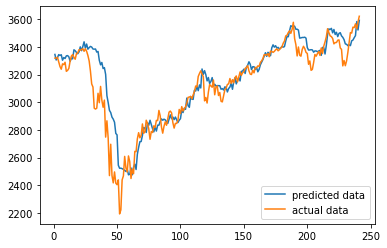

In [220]:
x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, predicted_y_2[:,0], label='predicted data')
plt.plot(x_axis, actual_y[:,0], label='actual data')
plt.legend()

RMSE =  150.41829196854792


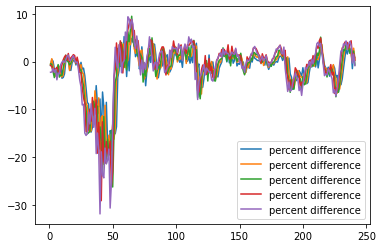

In [221]:
#print RMSE
mse = mean_squared_error(actual_y, predicted_y_2)
rmse = math.sqrt(mse)
print("RMSE = ",rmse)

def percent_diff(actual, predicted):
    return ((actual-predicted)/actual) * 100

#get percent difference between actual and predicted
difference = []
for i in range(0,len(actual_y)):
    difference.append(percent_diff(actual_y[i],predicted_y_2[i]))

x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, difference, label='percent difference')
plt.legend()

## LSTM MODEL (2000 Epochs with SGD)
Creating a 5 day closing stock price forecasting model with LSTM with 2000 epochs using nadam

In [222]:
optimizer_3 = "nadam"
model_name_3 = "stock_model_3.h5"
history_name_3 = "stock_model_history_3.csv"

In [223]:
model_3 = None
model_history_3 = pd.DataFrame()

if os.path.exists(model_name_3):
    print("Model Found: Loading...")
    model_3 = load_model(model_name_3)
    model_history_3 = pd.read_csv(history_name_3)
    print(model_3.summary())
    print("Model Loaded!")
else:
    print("Model not Found. Fitting model...")
    model_3, model_history_3 = stock_model(num_features, epochs, optimizer_3, model_name_3, history_name_3)
    model_history_3 = model_history_3.history

Model not Found. Fitting model...
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 100)               42400     
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 505       
Total params: 42,905
Trainable params: 42,905
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2000
152/152 [==============================] - 1s 9ms/step - loss: 89493.6328 - val_loss: 36761.5508
Epoch 2/2000
152/152 [==============================] - 1s 7ms/step - loss: 13021.7871 - val_loss: 11513.5635
Epoch 3/2000
152/152 [==============================] - 1s 7ms/step - loss: 4950.2563 - val_loss: 7498.3857
Epoch 4/2000
152/152 [==============================] - 1s 7ms/step - loss: 3429.2930 - val_loss: 6636.0557
Epoch 5/2000
152/152 [===============

Epoch 71/2000
152/152 [==============================] - 1s 7ms/step - loss: 145.9763 - val_loss: 274.8338
Epoch 72/2000
152/152 [==============================] - 1s 7ms/step - loss: 141.5575 - val_loss: 133.5639
Epoch 73/2000
152/152 [==============================] - 1s 7ms/step - loss: 138.5992 - val_loss: 149.7804
Epoch 74/2000
152/152 [==============================] - 1s 7ms/step - loss: 138.9025 - val_loss: 135.5716
Epoch 75/2000
152/152 [==============================] - 1s 8ms/step - loss: 132.8860 - val_loss: 315.2443
Epoch 76/2000
152/152 [==============================] - 1s 7ms/step - loss: 132.8852 - val_loss: 354.5755
Epoch 77/2000
152/152 [==============================] - 1s 7ms/step - loss: 131.1393 - val_loss: 232.0331
Epoch 78/2000
152/152 [==============================] - 1s 7ms/step - loss: 127.8920 - val_loss: 269.3506
Epoch 79/2000
152/152 [==============================] - 1s 7ms/step - loss: 125.1589 - val_loss: 191.6813
Epoch 80/2000
152/152 [==============

152/152 [==============================] - 1s 7ms/step - loss: 41.1807 - val_loss: 103.3171
Epoch 225/2000
152/152 [==============================] - 1s 7ms/step - loss: 41.0863 - val_loss: 88.2590
Epoch 226/2000
152/152 [==============================] - 1s 7ms/step - loss: 42.7649 - val_loss: 106.7787
Epoch 227/2000
152/152 [==============================] - 1s 7ms/step - loss: 41.0850 - val_loss: 109.6484
Epoch 228/2000
152/152 [==============================] - 1s 7ms/step - loss: 40.9049 - val_loss: 93.2958
Epoch 229/2000
152/152 [==============================] - 1s 7ms/step - loss: 41.8529 - val_loss: 111.5397
Epoch 230/2000
152/152 [==============================] - 1s 7ms/step - loss: 41.8716 - val_loss: 90.2773
Epoch 231/2000
152/152 [==============================] - 1s 7ms/step - loss: 41.7267 - val_loss: 120.0617
Epoch 232/2000
152/152 [==============================] - 1s 7ms/step - loss: 40.1029 - val_loss: 91.9657
Epoch 233/2000
152/152 [==============================] 

152/152 [==============================] - 1s 7ms/step - loss: 35.3600 - val_loss: 108.1279
Epoch 302/2000
152/152 [==============================] - 1s 7ms/step - loss: 34.9139 - val_loss: 91.2378
Epoch 303/2000
152/152 [==============================] - 1s 7ms/step - loss: 35.5599 - val_loss: 105.3917
Epoch 304/2000
152/152 [==============================] - 1s 7ms/step - loss: 34.1477 - val_loss: 89.5748
Epoch 305/2000
152/152 [==============================] - 1s 7ms/step - loss: 35.0173 - val_loss: 101.4803
Epoch 306/2000
152/152 [==============================] - 1s 7ms/step - loss: 34.5398 - val_loss: 93.6726
Epoch 307/2000
152/152 [==============================] - 1s 7ms/step - loss: 35.1814 - val_loss: 91.1429
Epoch 308/2000
152/152 [==============================] - 1s 7ms/step - loss: 34.0822 - val_loss: 102.4264
Epoch 309/2000
152/152 [==============================] - 1s 7ms/step - loss: 33.8122 - val_loss: 90.8651
Epoch 310/2000
152/152 [==============================] -

152/152 [==============================] - 1s 7ms/step - loss: 28.9588 - val_loss: 92.1008
Epoch 379/2000
152/152 [==============================] - 1s 7ms/step - loss: 28.9157 - val_loss: 96.2217
Epoch 380/2000
152/152 [==============================] - 1s 7ms/step - loss: 29.8305 - val_loss: 96.8365
Epoch 381/2000
152/152 [==============================] - 1s 7ms/step - loss: 29.9552 - val_loss: 91.3030
Epoch 382/2000
152/152 [==============================] - 1s 7ms/step - loss: 29.6118 - val_loss: 105.8248
Epoch 383/2000
152/152 [==============================] - 1s 7ms/step - loss: 29.0184 - val_loss: 94.4372
Epoch 384/2000
152/152 [==============================] - 1s 7ms/step - loss: 29.4103 - val_loss: 92.3491
Epoch 385/2000
152/152 [==============================] - 1s 7ms/step - loss: 29.0262 - val_loss: 92.8831
Epoch 386/2000
152/152 [==============================] - 1s 7ms/step - loss: 29.2662 - val_loss: 91.1813
Epoch 387/2000
152/152 [==============================] - 1s

152/152 [==============================] - 1s 7ms/step - loss: 26.7748 - val_loss: 100.4264
Epoch 533/2000
152/152 [==============================] - 1s 7ms/step - loss: 27.3192 - val_loss: 92.7909
Epoch 534/2000
152/152 [==============================] - 1s 7ms/step - loss: 27.5223 - val_loss: 109.2406
Epoch 535/2000
152/152 [==============================] - 1s 7ms/step - loss: 27.6867 - val_loss: 95.7659
Epoch 536/2000
152/152 [==============================] - 1s 7ms/step - loss: 27.6085 - val_loss: 96.3817
Epoch 537/2000
152/152 [==============================] - 1s 7ms/step - loss: 27.2168 - val_loss: 94.1912
Epoch 538/2000
152/152 [==============================] - 1s 7ms/step - loss: 27.3063 - val_loss: 93.2624
Epoch 539/2000
152/152 [==============================] - 1s 7ms/step - loss: 27.4540 - val_loss: 94.0115
Epoch 540/2000
152/152 [==============================] - 1s 7ms/step - loss: 27.4801 - val_loss: 94.2214
Epoch 541/2000
152/152 [==============================] - 1

152/152 [==============================] - 1s 7ms/step - loss: 27.1791 - val_loss: 92.8238
Epoch 687/2000
152/152 [==============================] - 1s 7ms/step - loss: 27.0003 - val_loss: 94.8545
Epoch 688/2000
152/152 [==============================] - 1s 7ms/step - loss: 27.0472 - val_loss: 95.6858
Epoch 689/2000
152/152 [==============================] - 1s 7ms/step - loss: 26.8576 - val_loss: 91.1965
Epoch 690/2000
152/152 [==============================] - 1s 7ms/step - loss: 26.4408 - val_loss: 94.8433
Epoch 691/2000
152/152 [==============================] - 1s 7ms/step - loss: 27.0369 - val_loss: 91.6786
Epoch 692/2000
152/152 [==============================] - 1s 7ms/step - loss: 26.4002 - val_loss: 105.9310
Epoch 693/2000
152/152 [==============================] - 1s 7ms/step - loss: 26.7268 - val_loss: 96.7270
Epoch 694/2000
152/152 [==============================] - 1s 7ms/step - loss: 27.6315 - val_loss: 100.2965
Epoch 695/2000
152/152 [==============================] - 1

152/152 [==============================] - 1s 7ms/step - loss: 23.5482 - val_loss: 73.8760
Epoch 841/2000
152/152 [==============================] - 1s 7ms/step - loss: 24.3802 - val_loss: 75.7490
Epoch 842/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.2818 - val_loss: 74.7146
Epoch 843/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.6666 - val_loss: 80.6241
Epoch 844/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.7499 - val_loss: 79.7549
Epoch 845/2000
152/152 [==============================] - 1s 7ms/step - loss: 24.3803 - val_loss: 80.0218
Epoch 846/2000
152/152 [==============================] - 1s 7ms/step - loss: 24.3751 - val_loss: 73.6088
Epoch 847/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.9214 - val_loss: 94.0842
Epoch 848/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.5193 - val_loss: 73.3588
Epoch 849/2000
152/152 [==============================] - 1s 

152/152 [==============================] - 1s 7ms/step - loss: 23.1485 - val_loss: 73.2384
Epoch 995/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.4080 - val_loss: 70.7288
Epoch 996/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.0309 - val_loss: 71.2003
Epoch 997/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.7016 - val_loss: 70.4775
Epoch 998/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.1998 - val_loss: 71.7605
Epoch 999/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.6096 - val_loss: 71.3417
Epoch 1000/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.7226 - val_loss: 70.5244
Epoch 1001/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.1301 - val_loss: 73.5128
Epoch 1002/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.5734 - val_loss: 71.4799
Epoch 1003/2000
152/152 [==============================] -

152/152 [==============================] - 1s 8ms/step - loss: 22.5605 - val_loss: 71.0263
Epoch 1147/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.2785 - val_loss: 70.5328
Epoch 1148/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.9379 - val_loss: 68.6789
Epoch 1149/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.4585 - val_loss: 71.9356
Epoch 1150/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.4823 - val_loss: 73.4467
Epoch 1151/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.3583 - val_loss: 69.9809
Epoch 1152/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.9576 - val_loss: 78.0508
Epoch 1153/2000
152/152 [==============================] - 1s 8ms/step - loss: 22.7796 - val_loss: 76.7137
Epoch 1154/2000
152/152 [==============================] - 1s 7ms/step - loss: 23.7218 - val_loss: 70.0978
Epoch 1155/2000
152/152 [============================

152/152 [==============================] - 1s 7ms/step - loss: 22.7392 - val_loss: 68.8046
Epoch 1299/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.3997 - val_loss: 84.5851
Epoch 1300/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.3029 - val_loss: 75.0306
Epoch 1301/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.9131 - val_loss: 70.7655
Epoch 1302/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.3380 - val_loss: 69.8980
Epoch 1303/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.3090 - val_loss: 71.1108
Epoch 1304/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.0576 - val_loss: 83.4089
Epoch 1305/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.6027 - val_loss: 68.9491
Epoch 1306/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.0934 - val_loss: 68.7342
Epoch 1307/2000
152/152 [============================

152/152 [==============================] - 1s 7ms/step - loss: 22.1129 - val_loss: 73.8056
Epoch 1451/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.0113 - val_loss: 76.0541
Epoch 1452/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.8856 - val_loss: 70.2683
Epoch 1453/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.9789 - val_loss: 77.9213
Epoch 1454/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.1083 - val_loss: 73.0699
Epoch 1455/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.8492 - val_loss: 68.7739
Epoch 1456/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.7543 - val_loss: 72.2906
Epoch 1457/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.3295 - val_loss: 70.5401
Epoch 1458/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.1736 - val_loss: 69.4386
Epoch 1459/2000
152/152 [============================

152/152 [==============================] - 1s 7ms/step - loss: 22.0405 - val_loss: 68.2426
Epoch 1603/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.3707 - val_loss: 71.5895
Epoch 1604/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.3290 - val_loss: 75.3958
Epoch 1605/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.5733 - val_loss: 70.4835
Epoch 1606/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.9971 - val_loss: 68.3069
Epoch 1607/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.7309 - val_loss: 68.5303
Epoch 1608/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.6540 - val_loss: 72.7745
Epoch 1609/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.6792 - val_loss: 70.0023
Epoch 1610/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.9067 - val_loss: 68.8477
Epoch 1611/2000
152/152 [============================

152/152 [==============================] - 1s 7ms/step - loss: 20.9282 - val_loss: 68.6657
Epoch 1755/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.5977 - val_loss: 68.2737
Epoch 1756/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.0829 - val_loss: 76.7271
Epoch 1757/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.4962 - val_loss: 69.7959
Epoch 1758/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.7004 - val_loss: 68.7373
Epoch 1759/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.5426 - val_loss: 70.7774
Epoch 1760/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.0162 - val_loss: 75.4132
Epoch 1761/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.4638 - val_loss: 71.0053
Epoch 1762/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.9593 - val_loss: 68.2969
Epoch 1763/2000
152/152 [============================

152/152 [==============================] - 1s 7ms/step - loss: 21.6101 - val_loss: 68.4302
Epoch 1907/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.9438 - val_loss: 82.8269
Epoch 1908/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.1180 - val_loss: 72.6077
Epoch 1909/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.1479 - val_loss: 68.7882
Epoch 1910/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.4873 - val_loss: 71.7861
Epoch 1911/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.3539 - val_loss: 68.2760
Epoch 1912/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.6228 - val_loss: 68.9324
Epoch 1913/2000
152/152 [==============================] - 1s 7ms/step - loss: 21.5410 - val_loss: 75.1315
Epoch 1914/2000
152/152 [==============================] - 1s 7ms/step - loss: 22.0738 - val_loss: 71.5068
Epoch 1915/2000
152/152 [============================

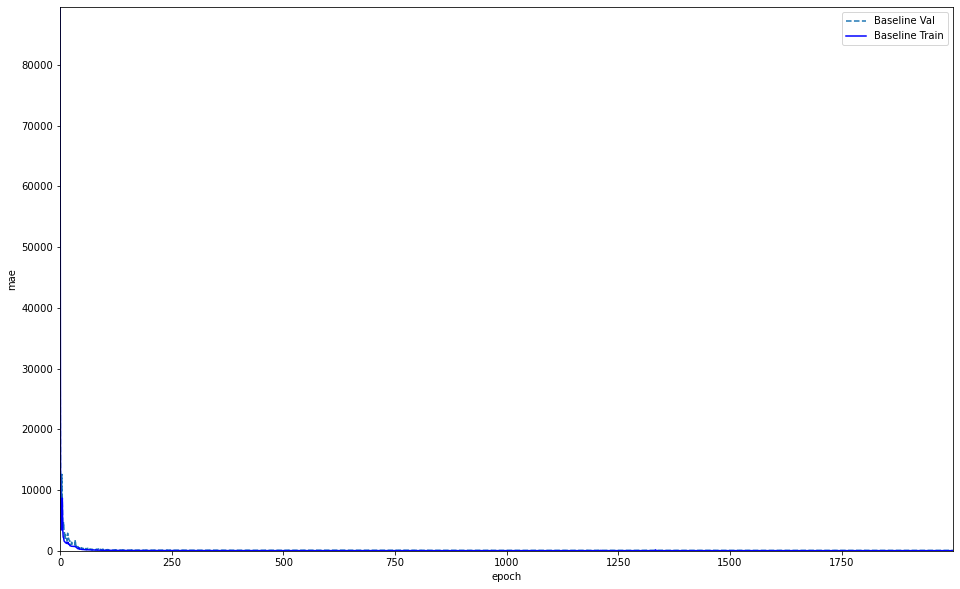

In [224]:
plt.figure(figsize=(16,10))
plt.plot(np.arange(0,epochs,1), model_history_3['val_loss'],'--', label='Baseline Val')
plt.plot(np.arange(0,epochs,1), model_history_3['loss'], color='blue', label='Baseline Train')
plt.ylabel("mae")
plt.xlabel("epoch")
plt.xlim([0,max(np.arange(0,epochs,1))])
plt.ylim([0,max(max(model_history_3['val_loss']),max(model_history_3['loss']))])
plt.legend()
plt.show()

In [225]:
predicted_y_3 = check_all_test_data(test_x, model_3)
print("End of data prediction!")

....................- 20
....................- 40
....................- 60
....................- 80
....................- 100
....................- 120
....................- 140
....................- 160
....................- 180
....................- 200
....................- 220
....................- 240
.- 242
End of data prediction!


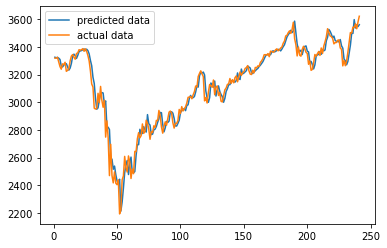

In [226]:
x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, predicted_y_3[:,0], label='predicted data')
plt.plot(x_axis, actual_y[:,0], label='actual data')
plt.legend()

RMSE =  99.01501352984091


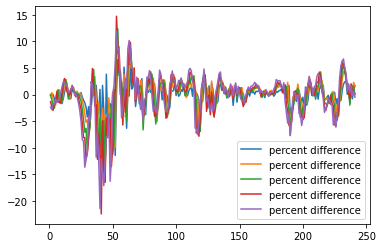

In [227]:
#print RMSE
mse = mean_squared_error(actual_y, predicted_y_3)
rmse = math.sqrt(mse)
print("RMSE = ",rmse)

def percent_diff(actual, predicted):
    return ((actual-predicted)/actual) * 100

#get percent difference between actual and predicted
difference = []
for i in range(0,len(actual_y)):
    difference.append(percent_diff(actual_y[i],predicted_y_3[i]))

x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, difference, label='percent difference')
plt.legend()

## Naive Model (Moving Average)

In [232]:
test_values = test_data[:,3]
moving_averages_pred = []

for i in range(len(test_values)):
    end = i + NUMBER_OF_DAYS_DATA_TO_USE
    
    if end+1 > len(test_values) or end+NUMBER_OF_DAYS_DATA_TO_PREDICT > len(test_values):
            break
    
    moving_prediction_set = list(test_values[i:end])
    
    for x in range(NUMBER_OF_DAYS_DATA_TO_PREDICT):
        
        end_x = x + NUMBER_OF_DAYS_DATA_TO_USE
        
        pred_value = np.mean(moving_prediction_set[x:end_x])         
        
        moving_prediction_set.append(pred_value)
                          
    moving_averages_pred.append(moving_prediction_set[NUMBER_OF_DAYS_DATA_TO_USE:NUMBER_OF_DAYS_DATA_TO_USE+NUMBER_OF_DAYS_DATA_TO_PREDICT])
    
moving_averages_pred = np.array(moving_averages_pred)

moving_averages_pred

array([[3273.81666667, 3274.80444444, 3277.42474074, 3281.11972346,
        3283.62770502],
       [3277.85      , 3280.67333333, 3284.58488889, 3287.32388148,
        3290.79547358],
       [3283.46666667, 3287.56444444, 3290.50207407, 3294.18554568,
        3296.44791539],
       ...,
       [3417.56666667, 3415.45444444, 3413.03474074, 3414.33705679,
        3416.42619391],
       [3423.11666667, 3421.20777778, 3423.05496296, 3425.72529383,
        3436.54031342],
       [3431.8       , 3434.35333333, 3437.77688889, 3449.39534815,
        3459.20503802]])

In [229]:
naive_mse = mean_squared_error(actual_y, moving_averages_pred)
naive_rmse = math.sqrt(naive_mse)
print("RMSE for the naive moving average model = ",naive_rmse)

RMSE for the naive moving average model =  150.12993388495775


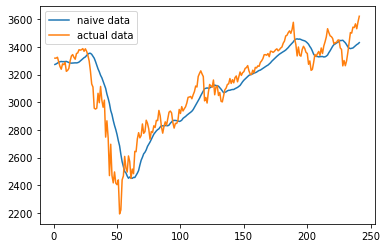

In [230]:
x_axis = np.arange(1,len(actual_y)+1)
plt.plot(x_axis, moving_averages_pred[:,0], label='naive data')
plt.plot(x_axis, actual_y[:,0], label='actual data')
plt.legend()

## DEMO

In [281]:
sample = np.array([test_data[15:30]])
sample_actual = test_data[30:35,3]

def predict_with_model(model, data):
    prediction = model.predict(sample)
    return prediction[0]

In [284]:
print("Stock closing price predictions for the next 5 days")
for each in predict_with_model(model_2, sample):
    print(each)

print("\nActual stock closing prices for the next 5 days")   
for each in sample_actual:
    print(each)

Stock closing price predictions for the next 5 days
3380.1875
3373.5261
3375.6643
3358.571
3370.674

Actual stock closing prices for the next 5 days
3325.5
3311.75
3353.0
3357.5
3380.5
